In [12]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import rayleigh
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

SCALE  = 7.35
N      = 10000
N_BINS = 160

# 1 
Generar una muestra aleatoria de $10,000$ puntos de la distribución de $Rayleigh$ utilizando `scale = 7.53`.

In [6]:
def rayleigh_pdf(n_samples, scale=SCALE):
    rx = np.linspace(0, max(rayleigh_data), n_samples)
    return ((rx /SCALE **2) * np.exp(-rx**2 / (2 * SCALE**2)))

# Datos de entrada (features)
rayleigh_data = np.random.rayleigh(scale=SCALE, size=N)
# Datos reales (labels)
rx = np.linspace(0, max(rayleigh_data), N)
ray_pdf = rayleigh_pdf(N) 

rayleigh_data.shape, ray_pdf.shape 

((10000,), (10000,))

# 2
Obtén $160$ puntos del histograma de tu muestra.

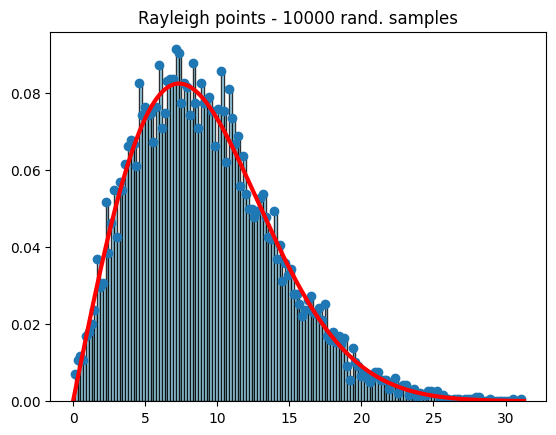

In [8]:
hist, bin_edges = np.histogram(rayleigh_data, bins=N_BINS, density=True)
plt.hist(rayleigh_data, bins=N_BINS, density=True, alpha=0.8, color='skyblue', edgecolor='black')
plt.scatter(bin_edges[:-1],hist)
plt.plot(rx, ray_pdf, 'r', linewidth=3)
plt.title('Rayleigh points - 10000 rand. samples')
plt.show()

# 3
Divide los puntos en conjunto de entrenamiento y prueba (80-20).

In [10]:
#X_train, X_test, Y_train, Y_test = train_test_split(bin_edges[:-1], hist, test_size=0.2, random_state=0)
X_train, X_test = train_test_split(rayleigh_data, test_size=0.2, random_state=0)
Y_train = rayleigh.pdf(X_train, scale=SCALE)
Y_test  = rayleigh.pdf(X_test, scale=SCALE)
X_train.shape, Y_train.shape, Y_test.shape, Y_test.shape

((8000,), (8000,), (2000,), (2000,))

# 4 
Realiza una regresión polinomial del conjunto de entrenamiento probando distintos grados
de polinomio. Calcula el sesgo y varianza para cada grado utilizado (Es posible que
tengas que dividir tu conjunto de entrenamiento en entrenamiento y validación). Imprime
los resultados en un dataframe de pandas: grado del polinomio, sesgo, varianza, $MAE,
MSE, R2$.

In [15]:
def reshape_data(X, y):
    return X.reshape(-1,1), y.reshape(-1,1)

def to_polynomial(X, deg):
    return PolynomialFeatures(degree=deg).fit_transform(X)

def compute_metrics(x_true_pol, y_true, y_hat):
    mae  = mean_absolute_error(y_true, y_hat)
    mse  = mean_squared_error(y_true, y_hat)
    r2   = r2_score(y_true, y_hat)
    bias = np.mean(((x_true_pol) - np.mean(y_hat))**2)
    var  = np.var(y_hat)
    return mae, mse, r2, bias, var

def create_model_df(max_deg, normalized=False):
    df = pd.DataFrame(columns=['grado_modelo', 'mae', 'mse', 'r2_score', 'sesgo', 'varianza'])
    
    model = None
    if(normalized):
        model = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1])
    else:
        model = LinearRegression()
    
    for deg in range(1, max_deg + 1):
        x_train, y_train = reshape_data(X_train, Y_train)
        x_test, y_test   = reshape_data(X_test, Y_test)
        x_train_pol = to_polynomial(x_train, deg)
        x_test_pol  = to_polynomial(x_test, deg)
        model.fit(x_train_pol, y_train)
        y_hat   = model.predict(x_test_pol)
        
        mae, mse, r2, bias, var = compute_metrics(x_test_pol, y_test, y_hat)
        
        df.loc[len(df.index)] = [deg, mae, mse, r2, bias, var]
        
    return df

def polynomial_model_linear(max_deg):
    return create_model_df(max_deg)
        #y_train = PolynomialFeatures(degree=deg).fit_transform(y_train)
        #results = cross_validate(model, x_train, y_train, 
        #                        cv=5, n_jobs=-1, 
        #                        scoring=('neg_mean_absolute_error',
        #                                 'neg_mean_squared_error', 
        #                                 'r2'))
        #print(f"Modelo de grado {deg}\n")
        #print(f"MAE: {max(results['test_neg_mean_absolute_error'])}")
        #print(f"MSE: {max(results['test_neg_mean_squared_error'])}")
        #print(f"R2: {max(results['test_r2'])}")
        #print()

In [19]:
df = polynomial_model_linear(10)
df

,grado_modelo,mae,mse,r2_score,sesgo,varianza
0,1.0,0.014942,3.419042e-04,0.303537,5.467221e+01,0.000134
1,2.0,0.009395,1.411878e-04,0.712399,7.958128e+03,0.000329
2,3.0,0.002173,8.298576e-06,0.983096,1.897703e+06,0.000485
3,4.0,0.001426,3.559382e-06,0.992749,6.177982e+08,0.000491
4,5.0,0.000844,1.195104e-06,0.997566,2.483555e+11,0.000490
5,6.0,0.000124,3.455372e-08,0.999930,1.159992e+14,0.000491
6,7.0,0.000103,2.029065e-08,0.999959,6.047775e+16,0.000491
7,8.0,0.000035,2.441130e-09,0.999995,3.423399e+19,0.000491
8,9.0,0.000005,4.300635e-11,1.000000,2.062671e+22,0.000491
9,10.0,0.000012,6.238824e-10,0.999999,1.303802e+25,0.000492


# 5
Repite el análisis del punto 4 pero utilizando regularización y validación cruzada.

In [17]:
def polynomial_model_ridgecv(max_deg):
    return create_model_df(max_deg, normalized=True)

In [18]:
df_2 = polynomial_model_ridgecv(10)
df_2

,grado_modelo,mae,mse,r2_score,sesgo,varianza
0,1.0,1.494187e-02,3.419043e-04,3.035368e-01,5.467221e+01,1.344696e-04
1,2.0,9.394847e-03,1.411882e-04,7.123980e-01,7.958128e+03,3.288834e-04
2,3.0,2.174941e-03,8.302760e-06,9.830872e-01,1.897703e+06,4.846148e-04
3,4.0,2.400681e-02,1.826195e-03,-2.719982e+00,6.177982e+08,9.988274e-04
4,5.0,1.093789e+01,5.475198e+02,-1.115303e+06,2.483555e+11,5.481338e+02
5,6.0,2.630817e+04,4.403744e+09,-8.970479e+12,1.159997e+14,4.403694e+09
6,7.0,1.744205e+04,2.650748e+09,-5.399606e+12,6.047775e+16,2.650745e+09
7,8.0,3.580126e+07,1.498154e+16,-3.051758e+19,3.423444e+19,1.498115e+16
8,9.0,2.530225e+11,9.788635e+23,-1.993957e+27,2.083495e+22,9.787816e+23
9,10.0,2.977864e+14,1.724377e+30,-3.512577e+33,3.108419e+26,1.724084e+30


# 6
Presenta tu mejor modelo polinomial y argumenta por qué es el mejor.

Consideraremos el mejor modelo basándonos primero en la métrica $R^2$. Dado que, para grados altos los datos comienzan a tener 
una dimensionalidad mayor, las métricas $MAE$ y $MSE$ nos dan valores poco representativos del verdadero error que el modelo presenta, mientras que la métrica elegida presenta información más útil y adecuada para evaluar un modelo polinomial. 

Podremos extraer el mejor modelo de ambos dataframes (modelos no regularizados y regularizados usando `RidgeCV`) buscando el máximo para la métrica `r2_score` y compararemos los mejores obtenidos entre ellos mismos para conocer el mejor. Sin embargo, esto no es suficiente para decidirnos entre estos dos; recordemos que buscamos un balance entre varianza y sesgo, por lo que elegiremos el modelo que tenga ambas métricas lo más balanceadas posible.

In [20]:
best_nonreg = df.iloc[df['r2_score'].argmax()]
best_reg    = df_2.iloc[df_2['r2_score'].argmax()]
best_models = pd.DataFrame([best_nonreg, best_reg], columns=df.columns)
best_models.insert(0, "categoria", ['non_reg', 'reg'])
best_models

,categoria,grado_modelo,mae,mse,r2_score,sesgo,varianza
8,non_reg,9.0,0.000005,4.300635e-11,1.000000,2.062671e+22,0.000491
2,reg,3.0,0.002175,8.302760e-06,0.983087,1.897703e+06,0.000485


Observamos que el modelo regularizado posee una vairanza y un sesgo mucho menor a los presentados por el modelo no regularizado, además de un valor de $R^2$ aceptable. Auque el modelo no regularizado presenta una puntuación perfecta, este posee valores muy altos en cuanto a sesgo y varianza, por lo que decidiremos utilizar el modelo regularizado.

In [25]:
def build_model(model_deg):
    x_train, y_train = reshape_data(X_train, Y_train)
    x_test, y_test   = reshape_data(X_test, Y_test)
    x_train_pol      = to_polynomial(x_train, model_deg)
    x_test_pol       = to_polynomial(x_test, model_deg)
    model = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1], cv=5).fit(x_train_pol, y_train)
    print(*compute_metrics(x_test_pol, y_test, model.predict(x_test_pol)))
    return model

best_model = build_model(3)

0.002174955617200443 8.302404530120645e-06 0.9830879012340623 1897702.7966572966 0.0004845998127476248


# 7
Utiliza la distribución de Rayleigh utilizando el estimador máximo verosímil: `scale = MLE` y compáralo con el modelo polinomial presentado en el punto 6, probando su rendimiento el el conjunto de prueba.

In [35]:
MLE = np.sqrt((1 / 2*len(X_test)) * np.sum(X_test**2))
rayleigh_mle = np.random.rayleigh(scale=MLE, size=len(Y_test))
_, y_test   = reshape_data(X_test, Y_test)

mle_mae = mean_absolute_error(y_test, rayleigh_mle)
mle_mse = mean_squared_error(y_test, rayleigh_mle)
mle_r2  = r2_score(y_test, rayleigh_mle)    

mle_mae, mle_mse, mle_r2

(18489.768157648265, 435136464.1832958, -886378257313.5555)